## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import optuna

In [3]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account_Balance                    1000 non-null   int64
 2   Duration_of_Credit_monthly         1000 non-null   int64
 3   Payment_Status_of_Previous_Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit_Amount                      1000 non-null   int64
 6   Value_Savings_Stocks               1000 non-null   int64
 7   Length_of_current_employment       1000 non-null   int64
 8   Instalment_per_cent                1000 non-null   int64
 9   Sex_Marital_Status                 1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration_in_Current_address        1000 non-null   int64
 12  Most_valuable_availab

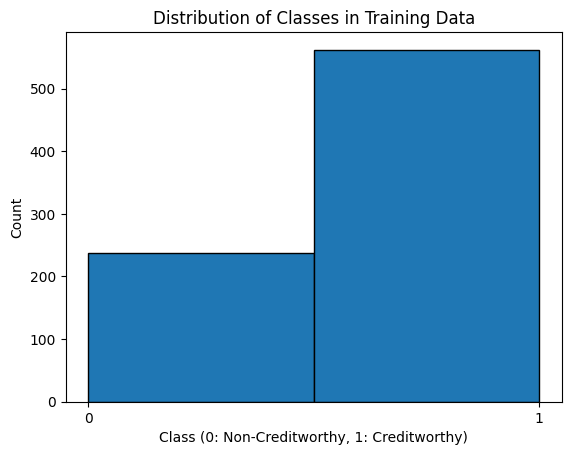

In [5]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

Гиперпараметры LogisticRegression:
1) "penalty" = "l2" - метод-регуляризации
2) "dual" = False - метод решения линейной системы уравнений. Зависит от значения отношения кол-ва признаков к кол-ву данных и от оптимизатора. В нашем случае dual должен быть равен True, так как lbfgs не решает систему линейных уравнений напрямую, а использует метод градиентного спуска
3) "tol" = 0.0001 - параметр толерантности в условии остановки
4) "C" = 1 - обратный коэффициент регуляризации, чем меньше, тем сильнее регуляризация
5) "fit_intercept" = True - рассчёт параметра смещения на основе выборки. Обычно не требуется для нормализованных данных. Однако в моём случае метрики с False упали
6) "intercept_scaling" = 1 - множитель колонки смещения, который применяется к смещениям, если при fit_intercept=True solver не прибавляет смещения к предсказаниям автоматически
7) "class_weight" = None - весовые множители классов, используемые для борьбы с дисбалансом
8) "solver" = "lbfgs" - алгоритм обновления весов модели до момента сходимости
9) "max_iter" = 100 - кол-во шагов оптимизации весов. Попробовал значения 10, 100 и 1000. В моём случае на итоговые метрики особо не влияет
10) "multi_class" = "auto" - способ решения многоклассовой классификации: один классификатор + softmax ("multinomial") или классификатор на каждый класс ("ovr", "One-vs-Rest")
11) "warm_start" = False - используется для итеративного обучения с использованием прошлых весов, если True, то при втором и более вызове метода fit() модель будет обучаться не с нуля, а со старых весов
12) "l1_ratio" = None - весовой коэффициент lasso-регуляризации в Elastic Net


In [6]:
from sklearn.preprocessing import RobustScaler

# Разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализуем данные
scaler = RobustScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [10]:
# Создание модели Logistic Regression
logistic_regression_model = LogisticRegression(fit_intercept=True, max_iter=100, class_weight="balanced")
logistic_regression_model.fit(X_train_norm, y_train)

# Считаем метрики по результатам модели
y_prob_logistic = logistic_regression_model.predict_proba(X_test_norm)[:, 1]
y_pred_logistic = logistic_regression_model.predict(X_test_norm)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)

# Выводим метрики
print(f'Accuracy of Logistic Regression: {accuracy_logistic:.3f}')
print(f'ROC AUC of Logistic Regression: {roc_auc_logistic:.3f}')
print(f'Precision of Logistic Regression: {precision_logistic:.3f}')
print(f'Recall of Logistic Regression: {recall_logistic:.3f}')

Accuracy of Logistic Regression: 0.760
ROC AUC of Logistic Regression: 0.792
Precision of Logistic Regression: 0.888
Recall of Logistic Regression: 0.746


Результаты обучения:

Эксперимент №1<br>
Описание: параметры по умолчанию<br>
Accuracy of Logistic Regression: 0.735<br>
ROC AUC of Logistic Regression: 0.77945301542777<br>
Precision of Logistic Regression: 0.7575757575757576<br>
Recall of Logistic Regression: 0.9057971014492754<br>

Эксперимент №2<br>
Описание: стандратная нормализация<br>
Accuracy of Logistic Regression: 0.7<br>
ROC AUC of Logistic Regression: 0.5707106124357176<br>
Precision of Logistic Regression: 0.7010309278350515<br>
Recall of Logistic Regression: 0.9855072463768116<br>

Эксперимент №3<br>
Описание: нормализация с помощью RobustScaler<br>
Accuracy of Logistic Regression: 0.775<br>
ROC AUC of Logistic Regression: 0.793<br>
Precision of Logistic Regression: 0.808<br>
Recall of Logistic Regression: 0.884<br>

Эксперимент №4<br>
Описание: использование автоподсчета class_weights для борьбы с дисбалансом классов<br>
Accuracy of Logistic Regression: 0.760<br>
ROC AUC of Logistic Regression: 0.792<br>
Precision of Logistic Regression: 0.888<br>
Recall of Logistic Regression: 0.746<br>

Гиперпараметры DecisionTreeClassifier:
1) criterion['gini', 'entropy', 'log_loss'] - критерий деления, 'gini' - быстрая и простая, но менее интерпретируемая, 'entropy' - более медленная, но даёт информацию об неопределенности, 'log_loss' - медленная, но даёт "надежные" вероятности
2) splitter['best', 'random'] = 'best' - способ выбора граничного значения при разделения узла или выбора признака, по которому будет разделяться. 'best' будет перебирать все thresholds до тех пор, пока не найдет лучший по критерию
3) max_depth = None - максимальная глубина дерева, регулирует его сложность
4) min_samples_split = 2 - минимальное число элементов в узле, необходимое для разбиения этого узла
5) min_samples_leaf = 1 - минимальное кол-во элементов в листах дерева
6) max_features['auto', 'sqrt', 'log2'] = None - кол-во рассматриваемых фичей при делении узла
7) random_state - задание seed
8) max_leaf_nodes = None - в отличие от max_depth ограничивающего "длину пути", max_leaf_nodes ограничивает кол-во "конечных точек"
9) min_impurity_decrease = 0 - минимальное уменьшение критерия для разбиения узла
10) class_weight = None - веса для борьбы с дисбалансом классов
11) ccp_alpha = 0 - complexity parameter, обрезает дерево после того, как оно выросло, убирая неважные узлы и оставляя только те узлы, которые хорошо переносят знания на новые данные

In [ ]:
def DTC_objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    ccp_alpha = trial.suggest_float("ccp_alpha", 0.0, 0.05)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.05)

    classifier_obj = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        criterion=criterion,
        max_features=max_features,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42
    )

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3, scoring='roc_auc')
    roc_auc = score.mean()

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(DTC_objective, n_trials=1000)

[I 2025-10-07 23:52:11,087] A new study created in memory with name: no-name-54b27fc3-49f7-452a-9163-1805020e1ba1
[I 2025-10-07 23:52:11,099] Trial 0 finished with value: 0.6646201703510285 and parameters: {'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 12, 'ccp_alpha': 0.03740671763154423, 'criterion': 'entropy', 'max_features': None, 'min_impurity_decrease': 0.020356305793663633}. Best is trial 0 with value: 0.6646201703510285.
[I 2025-10-07 23:52:11,112] Trial 1 finished with value: 0.6978705251289851 and parameters: {'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 15, 'ccp_alpha': 0.02195143693231316, 'criterion': 'entropy', 'max_features': None, 'min_impurity_decrease': 0.02181926549443521}. Best is trial 1 with value: 0.6978705251289851.
[I 2025-10-07 23:52:11,122] Trial 2 finished with value: 0.6646201703510285 and parameters: {'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 15, 'ccp_alpha': 0.01694726873586034, 'criterion': 'entropy', 

In [32]:
best = study.best_trial
print(best.value)
print(best.params)

0.7273202040285301
{'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 13, 'ccp_alpha': 0.005621993845139148, 'criterion': 'log_loss', 'max_features': None, 'min_impurity_decrease': 0.004346751293663784}


In [37]:
# Создание модели Decision Tree
decision_tree_model = DecisionTreeClassifier(
    max_depth=17,
    min_samples_split=6,
    min_samples_leaf=13,
    ccp_alpha=0.005621993845139148,
    criterion="log_loss",
    max_features=None,
    min_impurity_decrease=0.004346751293663784,
    random_state=42
)
decision_tree_model.fit(X_train, y_train)

# Считаем метрики по результатам модели
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_pred_decision_tree = decision_tree_model.predict(X_test)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)

# Выводим метрики
print(f'Accuracy of Decision Tree: {accuracy_decision_tree:.3f}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree:.3f}')
print(f'Precision of Decision Tree: {precision_decision_tree:.3f}')
print(f'Recall of Decision Tree: {recall_decision_tree:.3f}')

Accuracy of Decision Tree: 0.770
ROC AUC of Decision Tree: 0.764
Precision of Decision Tree: 0.780
Recall of Decision Tree: 0.928


Результаты обучения:

Эксперимент №1:<br>
Описание: параметры по умолчанию<br>
Accuracy of Decision Tree: 0.730<br>
ROC AUC of Decision Tree: 0.698<br>
Precision of Decision Tree: 0.818<br>
Recall of Decision Tree: 0.783<br>

Эксперимент №2:<br>
Описание: class_weights="balanced"<br>
Accuracy of Decision Tree: 0.740<br>
ROC AUC of Decision Tree: 0.678<br>
Precision of Decision Tree: 0.795<br>
Recall of Decision Tree: 0.841<br>

Эксперимент №3:<br>
Описание: использование optuna для подбора гиперпараметров<br>
Accuracy of Decision Tree: 0.770<br>
ROC AUC of Decision Tree: 0.764<br>
Precision of Decision Tree: 0.780<br>
Recall of Decision Tree: 0.928<br>


In [35]:
def KNN_objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    leaf_size = trial.suggest_int("leaf_size", 10, 100)
    p = trial.suggest_int("p", 1, 5)
    metric = trial.suggest_categorical("metric", ["minkowski", "euclidean", "manhattan", "chebyshev"])

    classifier_obj = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric
    )

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3, scoring='roc_auc')
    roc_auc = score.mean()

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(KNN_objective, n_trials=1000)

[I 2025-10-08 00:00:30,341] A new study created in memory with name: no-name-035bc10f-9f0b-45f5-abcd-dbf89fa695c3
[I 2025-10-08 00:00:31,980] Trial 0 finished with value: 0.5508823661433331 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 13, 'p': 3, 'metric': 'manhattan'}. Best is trial 0 with value: 0.5508823661433331.
[I 2025-10-08 00:00:32,708] Trial 1 finished with value: 0.523881999363416 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 29, 'p': 4, 'metric': 'chebyshev'}. Best is trial 0 with value: 0.5508823661433331.
[I 2025-10-08 00:00:33,429] Trial 2 finished with value: 0.534227893468677 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 14, 'p': 1, 'metric': 'euclidean'}. Best is trial 0 with value: 0.5508823661433331.
[I 2025-10-08 00:00:34,160] Trial 3 finished with value: 0.5641389877450381 and parameters: {'n_neighbors': 50, 'weights': 'u

In [36]:
best = study.best_trial
print(best.value)
print(best.params)

0.589693619349657
{'n_neighbors': 42, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 82, 'p': 2, 'metric': 'manhattan'}


In [38]:
# Создание модели K-Nearest Neighbors
knn_model = KNeighborsClassifier(
    n_neighbors=42,
    weights='uniform',
    algorithm='ball_tree',
    leaf_size=82,
    p=2,
    metric='manhattan'
)
knn_model.fit(X_train, y_train)

# Считаем метрики по результатам модели
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)

# Выводим метрики
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn:.3f}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn:.3f}')
print(f'Precision of K-Nearest Neighbors: {precision_knn:.3f}')
print(f'Recall of K-Nearest Neighbors: {recall_knn:.3f}')

Accuracy of K-Nearest Neighbors: 0.700
ROC AUC of K-Nearest Neighbors: 0.606
Precision of K-Nearest Neighbors: 0.705
Recall of K-Nearest Neighbors: 0.971


Результаты:

Эксперимент №1:<br>
Описание: параметры по умолчанию<br>
Accuracy of K-Nearest Neighbors: 0.660<br>
ROC AUC of K-Nearest Neighbors: 0.578<br>
Precision of K-Nearest Neighbors: 0.701<br>
Recall of K-Nearest Neighbors: 0.884<br>

Эксперимент №2:<br>
Описание: использование optuna для подбора гиперпараметров<br>
Accuracy of K-Nearest Neighbors: 0.700<br>
ROC AUC of K-Nearest Neighbors: 0.606<br>
Precision of K-Nearest Neighbors: 0.705<br>
Recall of K-Nearest Neighbors: 0.971<br>

## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели